In [251]:
### IMPORT PACKAGES ###

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn, optim
import torch.nn.functional as F


### LOAD SAVED COMBINED EMBEDDINGS ###

combind_embeds_correct_path = r'C:\Users\ppriyadarsha\Google Drive\1. UoP Stuff\1. SuSe_2020\Reinforcement Learning for NLP\Project\codes\rl4nlp\generate_combined_emb\combined_embeddings_correct.json'

with open(combind_embeds_correct_path,"r") as f:
     combined_embeds_correct_dic = json.load(f)
        
combind_embeds_incorrect_path = r'C:\Users\ppriyadarsha\Google Drive\1. UoP Stuff\1. SuSe_2020\Reinforcement Learning for NLP\Project\codes\rl4nlp\generate_combined_emb\combined_embeddings_incorrect.json'

with open(combind_embeds_incorrect_path,"r") as f:
     combined_embeds_incorrect_dic = json.load(f)

In [23]:
#### PREPARING TRAINING DATA ###

### Add `Related/Unrelated` classification to the combined embeddings  ###
combined_embeds_correct_w_class_dic = {}

for phrase, embeds_li in combined_embeds_correct_dic.items():    
    embeds_w_class = []
    
    for embed in embeds_li:
        embeds_w_class.append((embed,1)) ## when image and text are related - probabilit = 1
        
    combined_embeds_correct_w_class_dic[phrase] = embeds_w_class
    
    
combined_embeds_incorrect_w_class_dic = {}

for phrase, embeds_li in combined_embeds_incorrect_dic.items():
    embeds_w_class = []
    
    for embed in embeds_li:
        embeds_w_class.append((embed,0)) ## when image and text are related - probabilit = 0
        
    combined_embeds_incorrect_w_class_dic[phrase] = embeds_w_class

    
### CREATE SINGLE DICTIONARY + DF WITH ALL TRAINING SAMPLES ###

combined_embeds_w_class_final = {}

for incorrect_dic, correct_dic in zip(combined_embeds_incorrect_w_class_dic.items(),combined_embeds_correct_w_class_dic.items()):
    
    if incorrect_dic[0] == correct_dic[0]:
        combined_embeds_w_class_final[incorrect_dic[0]] = incorrect_dic[1] + correct_dic[1]

full_df_embeddings = pd.DataFrame(combined_embeds_w_class_final)

input_dfs_dic = {}
input_dfs_li = []

for key in combined_embeds_w_class_final.keys():
    temp_df = pd.DataFrame()
    temp_df.loc[:,'combined_embeds'] = full_df_embeddings[key].apply(lambda row: row[0])
    temp_df.loc[:,'correct_img_txt_combination'] = full_df_embeddings[key].apply(lambda row: row[1])    
    input_dfs_dic[key] = temp_df
    temp_df.loc[:,'phrase'] = key
    input_dfs_li.append(temp_df)
    
final_df = pd.concat(input_dfs_li)
final_df.combined_embeds = final_df.combined_embeds.apply(lambda arr: np.array(arr)) # convert to numpy arrays

In [109]:
final_df.sample(10)

,combined_embeds,correct_img_txt_combination,phrase
63,"[0.7407041192054749, -0.11425286531448364, 0.5...",0,phrase_6_turn_left
37,"[0.10063973814249039, -0.7761375904083252, -0....",0,phrase_1_go_through_opening
119,"[0.33274272084236145, -0.14996641874313354, -0...",0,phrase_7_turn_right
118,"[0.0009426474571228027, -1.1111305952072144, 0...",1,phrase_3_move_up
102,"[0.10063973814249039, -0.7761375904083252, -0....",0,phrase_1_go_through_opening
66,"[-0.6683769226074219, -0.655174732208252, 1.19...",0,phrase_2_move_down
126,"[0.16255351901054382, 0.27583223581314087, 0.9...",1,phrase_4_move_to_left
16,"[0.7407041192054749, -0.11425286531448364, 0.5...",0,phrase_6_turn_left
25,"[0.33274272084236145, -0.14996641874313354, -0...",0,phrase_7_turn_right
4,"[0.16255351901054382, 0.27583223581314087, 0.9...",0,phrase_4_move_to_left


In [151]:
### PROCESS TRAINING DATA + INITIALIZE THE MODEL ###

X = np.array(final_df.combined_embeds.tolist())
y = np.array(final_df.correct_img_txt_combination.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test).float())

class Classification_Net(nn.Module):
    
    def __init__(self, n_features):
        super(Classification_Net, self).__init__()
        self.fc1 = nn.Linear(n_features, int(7168/2))
        self.fc2 = nn.Linear(int(7168/2), int(7168/10))
        self.fc3 = nn.Linear(int(7168/10), int(7168/100))
        self.fc4 = nn.Linear(int(7168/100), 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

classify_net = Classification_Net(X_train.shape[1])

criterion = nn.BCELoss()
optimizer = optim.Adam(classify_net.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
classify_net = classify_net.to(device)
criterion = criterion.to(device)

def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [278]:
### TRAIN THE MODEL ###

for epoch in range(500):
    y_pred = classify_net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)

    if epoch % 50 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)
        y_test_pred = classify_net(X_test)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = criterion(y_test_pred, y_test)
        test_acc = calculate_accuracy(y_test, y_test_pred)
        print( f'''epoch {epoch}
                Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
                Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
                Train set - loss: 0.674, accuracy: 0.849
                Test  set - loss: 0.672, accuracy: 0.876
            
epoch 50
                Train set - loss: 0.362, accuracy: 0.849
                Test  set - loss: 0.347, accuracy: 0.876
            
epoch 100
                Train set - loss: 0.148, accuracy: 0.928
                Test  set - loss: 0.222, accuracy: 0.913
            
epoch 150
                Train set - loss: 0.007, accuracy: 1.0
                Test  set - loss: 0.111, accuracy: 0.963
            
epoch 200
                Train set - loss: 0.001, accuracy: 1.0
                Test  set - loss: 0.131, accuracy: 0.96
            
epoch 250
                Train set - loss: 0.0, accuracy: 1.0
                Test  set - loss: 0.145, accuracy: 0.96
            
epoch 300
                Train set - loss: 0.0, accuracy: 1.0
                Test  set - loss: 0.153, accuracy: 0.96
            
epoch 350
                Train set - loss: 0.0, accuracy: 

In [298]:
### SAVE THE TRAINED MODEL ###

torch.save(classify_net, 'classify_model.pth')


### CHECK MODEL ACCURACY ###

classes = ['Un-related', 'Related']
y_pred = classify_net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

  Un-related       0.97      0.99      0.98       262
     Related       0.90      0.76      0.82        37

    accuracy                           0.96       299
   macro avg       0.93      0.87      0.90       299
weighted avg       0.96      0.96      0.96       299



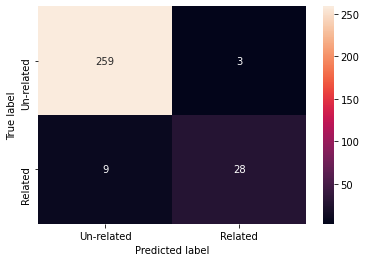

In [303]:
c_mat = confusion_matrix(y_test, y_pred)
df_c_mat = pd.DataFrame(c_mat, index=classes, columns=classes)
hmap = sns.heatmap(df_c_mat, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label');